<img src="logo.png" width=15%>

### <center>Instituto Superior De Engenharia De Lisboa<br>Departamento De Engenharia de Eletrónica e Telecomunicações e de Computadores<br>Licenciatura em Engenharia Informática e Multimédia

### <center>**Aprendizagem Automática** <br>2º Trabalho Laboratorial<br>Classificação de Críticas de Cinema do IMDb
##### <center>**Turma: 51D**<br>**Alunos:**<br>Ana Carriço 50725<br>Ana Medeiros 50761<br>Gabriel Rodrigues 50787<br></br>**Docente:** Gonçalo Marques<br></br>dezembro de 2024

# Índice

1. [Introdução](#intro)
2. [Construção do vocabulário ](#vocab)
3. [Classificação e regressão](#class)
4. [Metodologias de teste e metricas de desempenho](#teste)
5. [Clustering](#clustering)
6. [Conclusões](#conclusao)
7. [Referências](#refs)

<a id="intro"></a>

#### 1. Introdução

A IMDb, a Internet Movie Database, é uma base de dados que consiste em textos de críticas de cinema. Neste trabalho, os dados sao compostos por 50 000 textos de críticas de cinema com as respetivas pontuações, e encontram-se no ficheiro imdbFull.p.<br><br>A base de dados IMDb está estruturada para um problema de classificação binária onde é feita a determinação de uma crítica positiva ou negativa. Pode também ser usada noutros contextos como a **regressão**, prever o valor do rating baseado no texto da crítica, e o **clustering**, descobrir através das palavras partilhadas entre textos, se há certos grupos de documentos que se focam sobre temas ou areas específicas.<br><br>Este trabalho prático tem como objetivo reinar e avaliar um classificador multi-classe que prevê a pontuação da crítica. Para tal, deve-se também treinar e avaliar um regressor para prever a pontuação e fazer clustering das críticas.

In [2]:
import numpy as np
import pickle
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

<a id="vocab"></a>

#### 2. Construção do vocabulário

O **vocabulário** é a base para transformar textos em representações numéricas utilizáveis por modelos de aprendizagem automática, consistindo num conjunto de palavras ou tokens extraídos dos textos.

A construção do vocabulário é constituído pelas seguintes etapas:

1. **Pré-processamento dos Textos:**
   - **Limpeza:**
     - Remoção de caracteres especiais, números, etc.
     - Conversão para letras minúsculas.
     - Substituição de múltiplos espaços por um único espaço.
   - **Tokenization:**
     - Dividir os textos em palavras ou tokens.  

2. **Filtragem de Palavras Relevantes:**
   - **Remoção de Stop Words:**
     - Stop words são palavras comuns, como "the", "is", "and", que geralmente não carregam significado relevante para análise.
   - **Palavras de Tamanho Mínimo:**
     - Excluir palavras muito curtas (ex.: menos de 4 letras), que podem ser ruído.
   - **Stemming:**
     - Reduzir as palavras à sua raiz ou forma base.

3. **Extração de Características com o TF-IDF:**
   - **TF-IDF (Term Frequency-Inverse Document Frequency):**
     - Calcula a relevância de uma palavra.
     - Palavras que aparecem frequentemente em um documento, mas raramente em outros, recebem maior peso.
   - **Parâmetros Importantes:**
     - **min_df (frequência mínima):** Evita palavras raras que podem ser ruído.
     - **max_df (frequência máxima):** Remove palavras muito comuns, como stop words que ainda possam estar presentes.
     - **stop_words='english':** Usa uma lista pré-definida de stop words em inglês.
     - **token_pattern:** Define o padrão para identificar tokens válidos.

In [3]:
imdb = pickle.load(open("imdbFull.p", 'rb'))
X = imdb['data']
Y = imdb['target']

text=[doc.replace('<br />',' ') for doc in X]
text=[re.sub(r'[^a-zA-Z]+',' ',doc) for doc in text]

X_train, X_test, Y_train, Y_test = train_test_split(text, Y, test_size=1/2, random_state=42)

tp=r'\b\w\w\w\w+\b'

#Stemmer
snowB=SnowballStemmer('english')
X_train =[' '.join([snowB.stem(word) for word in doc.split()]) for doc in X_train]
X_test =[' '.join([snowB.stem(word) for word in doc.split()]) for doc in X_test]

# #Vectorização TF-IDF
tfidf=TfidfVectorizer(max_df=0.5, min_df=5,stop_words='english',token_pattern=tp, ngram_range=(1,2)).fit(X_train)

# X_train_tfidf= tfidf.transform(X_train)
# X_test_tfidf= tfidf.transform(X_test)
# tokens = tfidf.get_feature_names_out()

X_train_tfidf = pickle.load(open("X_train_tfidf.p", 'rb'))
X_test_tfidf= pickle.load(open("X_test_tfidf.p", 'rb'))
tokens = pickle.load(open("tokens.p", 'rb'))

Em primeiro lugar, carregou-se a base de dados das críticas de filmes no IMDb. Efetuou-se a **limpeza dos textos** ao substituir quebras de linha por espaços e remover caracteres que não sejam letras do alfabeto.<br><br>Dividiu-se os dados com 50% de dados de treino e 50% de dados de teste onde `random_state=42` é responsável por garantir a reprodutibilidade da divisão.<br><br>Definiu-se um padrão de tokenização onde apenas com palavras com **4 ou mais caracteres** são consideradas. Usou-se o **Stemmer Snowball** com o objetivo de reduzir as palavras às suas raízes, reduzindo, então, o vocabulário e ajudando o modelo a identificar padrões sem variações morfológicas.<br><br>Com o **TF-IDF Vectorization**, converteu.se os textos em representações numéricas, medindo a importância de uma palavra:
 - `max_df=0.5`: Ignora termos que aparecem em mais de 50% dos documentos;
 - `min_df=5`: Ignora termos que aparecem em menos de 5 documentos;
 - `stop_words='english'`: Remove palavras irrelevantes como "the", "is", etc.;
 - `token_pattern=tp`: Usa o padrão de tokenização definido;
 - `ngram_range=(1,2)`: Considera unigramas (palavras únicas) e bigramas (pares de palavras consecutivas).
<br><br>Na primeira vez que o código foi corrido, executou-se o transform das variáveis de treino e teste. Entretanto, para evitar uma longa espera, as variáveis foram guardadas num documento pickle de forma a simplesmente ler-se os documentos e a execução demorar menos tempo.

<a id="class"></a>

#### 3. Classificação e regressão

A **classificação** consiste na atribuição de uma classe a cada entrada com base nas suas características. Neste caso, identificou-se se uma crítica é **positiva** ou **negativa**.
Transformou-se as pontuações das críticas (1 a 10) em **duas classes**:
   - **Classe 1:** Pontuações de 1 a 4 (críticas negativas).
   - **Classe 2:** Pontuações de 7 a 10 (críticas positivas).

Utilizou-se a **Regressão Logística** como modelo de classificação.

Para avaliar a classificação...
   - **Exatidão**: Proporção de predições corretas sobre o total.
   - **Relatório de Classificação**:
     - **Precisão**: Quantos dos exemplos preditos como positivos realmente são positivos.
     - **Recall**: Quantos dos exemplos positivos reais foram corretamente identificados.
     - **F1-Score**: Média harmônica entre precisão e recall.

Já a **regressão** consiste na previsão de um **valor contínuo** para cada entrada com base nas características. Neste caso, estimou-se a pontuação de um filme com base nos textos das críticas.

Utilizou-se a **Regressão Linear** de forma a prever diretamente a **pontuação contínua** (1 a 10) das críticas e converter as predições para categorias (1-4 e 7-10) para comparar diretamente com a tarefa de classificação.

Para avaliar a regressão...
   - **Erro Quadrático Médio (MSE)**: Média dos quadrados das diferenças entre os valores preditos e reais.
   - **Raiz do Erro Quadrático Médio (RMSE)**: Raiz quadrada do MSE. Mede o desvio médio das predições em relação aos valores reais.

In [ ]:
Y_train_class = [1 if s <= 4 else 2 for s in Y_train]
Y_test_class = [1 if s <= 4 else 2 for s in Y_test]

classifier = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=1000, random_state=42, tol=1e-3)
classifier.fit(X_train_tfidf, Y_train_class)
pred_class = classifier.predict(X_test_tfidf)

w=classifier.coef_
idx=np.argsort(w).squeeze()
vocab = [tokens[i] for i in idx]

regressor = LinearRegression()
regressor.fit(X_train_tfidf, Y_train)
pred_reg = regressor.predict(X_test_tfidf)

print("\nPalavras mais influentes para a classe negativa (1-4):")
print(vocab[:20])
print("\nPalavras mais influentes para a classe positiva (7-10):")
print(vocab[-20:])

print('\nAcertos (treino) %.2f'%(classifier.score(X_train_tfidf,Y_train_class)*100),'%')
print('Acertos (teste) %.2f'%(classifier.score(X_test_tfidf,Y_test_class)*100),'%')


Palavras mais influentes para a classe negativa (1-4):
['worst', 'wast', 'poor', 'bore', 'noth', 'terribl', 'horribl', 'stupid', 'wors', 'disappoint', 'fail', 'script', 'suppos', 'minut', 'dull', 'annoy', 'save', 'ridicul', 'plot', 'wast time']

Palavras mais influentes para a classe positiva (7-10):
['entertain', 'fantast', 'recommend', 'definit', 'superb', 'today', 'veri', 'high recommend', 'hilari', 'surpris', 'beauti', 'amaz', 'favorit', 'enjoy', 'best', 'brilliant', 'love', 'perfect', 'excel', 'great']

Acertos (treino) 93.80 %
Acertos (teste) 88.44 %


Converteu-se os valores de treino e teste em classes binárias:
  - **Classe 1 (negativa)**: valores menores ou iguais a 4.
  - **Classe 2 (positiva)**: valors maiores que 4.

Para a classificação, utilizou-se o Modelo de Regressão Logística:
  - `C=1`: Define o parâmetro de regularização.
  - `penalty='l2'`: Utiliza regularização L2 para evitar overfitting.
  - `solver='saga'`: Otimizador robusto para grandes datasets esparsos (com TF-IDF).
  - `max_iter=1000`: Limita o número máximo de iterações para convergência.
  - `tol=1e-3`: Define a tolerância para convergência.

Após o treino, definiu-se as previsões para os dados de teste.

Para a regressão, utilizou-se o Modelo de Regressão Linear que prevê os valores contínuos das críticas.
- `classifier.coef_`: Obtém os coeficientes do modelo.
- `np.argsort(w)`: Ordena os coeficientes em ordem crescente.
- `tokens`: Vocabulário correspondente aos tokens vetorizados pelo TF-IDF.
- `vocab`: Lista de palavras (tokens) ordenada pela influência na decisão do modelo:
  - As palavras com coeficientes mais baixos (valores negativos) estão mais associadas à classe negativa.
  - As palavras com coeficientes mais altos (valores positivos) estão mais associadas à classe positiva.

Com o `classifier.score`, verificou-se o o desempenho do Modelo de Classificação:
 - Treino (93.80%) - o modelo conseguiu aprender bem os padrões dos dados de treino.
 - Teste (88.44%) - o modelo generaliza bem para novos dados.

<a id="teste"></a>

####  4. Metodologias de teste e métricas de desempenho

A escolha da metodologia de teste serve para avaliar corretamente o desempenho de modelos de aprendizado de máquina, garantindo que os resultados obtidos sejam representativos e confiáveis.

**Metodologias de Teste**<br>
Após a divisão dos dados em dois subconjuntos (`Y_train_class`,`Y_test_class`), pode se optar por:
 - dividi-los em K subconjuntos (folds) e o modelo é treinado em \(K-1\) folds e avaliado no fold restante (**Cross Validation**). Esta metodologia oferece uma estimativa mais robusta do desempenho, pois todos os dados são usados tanto para treino quanto para teste.
 - dividi-los em três subconjuntos: treino, validação e teste (**Train-Validation-Test Split**).

**Métricas de Desempenho**<br>
- **Exatidão:** proporção de predições corretas sobre o total de exemplos.
$$\text{Exatidão} = \frac{\text{Nº de predições corretas}}{\text{Total de exemplos}}$$

- **Precisão:** mede a proporção de predições positivas que estão corretas.
$$\text{Precisão} = \frac{\text{VP}}{\text{VP + FP}}$$

- **Sensibilidade:** mede a proporção de exemplos positivos reais que foram corretamente classificados.
$$\text{Recall} = \frac{\text{VP}}{\text{VP + FN}}$$

- **F1-Score:** média harmônica entre precisão e recall.
$$F1 = 2 \times \frac{\text{Precisão} \times \text{Recall}}{\text{Precisão} + \text{Recall}}$$

- **Matriz de Confusão:** mostra os erros de classificação para cada classe.<br><br>
- **Erro Absoluto Médio (MAE):** média das diferenças absolutas entre os valores reais e preditos.
$$\text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|$$

- **Erro Quadrático Médio (MSE):** média dos quadrados das diferenças entre os valores reais e preditos.
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

- **Raiz do Erro Quadrático Médio (RMSE):** raiz quadrada do MSE. Fornece uma interpretação direta no mesmo domínio dos dados.
   $$\text{RMSE} = \sqrt{\text{MSE}}$$

- **R² (Coeficiente de Determinação):** mede a proporção da variabilidade dos dados explicada pelo modelo.
   $$R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$$

In [5]:
# Avaliação do Classificador
accuracy = accuracy_score(Y_test_class, pred_class)
precision = precision_score(Y_test_class, pred_class)
recall = recall_score(Y_test_class, pred_class)
f1 = f1_score(Y_test_class, pred_class)
conf_matrix = confusion_matrix(Y_test_class, pred_class)

print("\nMétricas de Desempenho - Classificação:")
print('Exatidão: %.2f'%(accuracy*100),'%')
print('Precisão: %.2f'%(precision*100),'%')
print('Sensibilidade: %.2f'%(recall*100),'%')
print('F1-Score: %.2f'%(f1*100),'%')
print(f"\nMatriz de Confusão:\n{conf_matrix}")

# Validação cruzada do classificador
cv_scores = cross_val_score(classifier, X_train_tfidf, Y_train_class, cv=5)
print("\nValidação Cruzada - Classificação:")
print('Exatidão Média:%.2f'%(cv_scores.mean()*100),'%')

# Avaliação da Regressão
mse=mean_squared_error(Y_test, pred_reg)
rmse = np.sqrt(mse)
print("\nMétricas de Desempenho - Regressão:")
print("Erro Quadrático Médio (MSE): %.2f" % mse)
print("Raiz do Erro Quadrático Médio (RMSE): %.2f" % rmse)


Métricas de Desempenho - Classificação:
Exatidão: 88.44 %
Precisão: 89.41 %
Sensibilidade: 87.08 %
F1-Score: 88.23 %

Matriz de Confusão:
[[10831  1607]
 [ 1283 11279]]

Validação Cruzada - Classificação:
Exatidão Média:88.15 %

Métricas de Desempenho - Regressão:
Erro Quadrático Médio (MSE): 6.70
Raiz do Erro Quadrático Médio (RMSE): 2.59


 - Classificação:
   - Exatidão (88.44%) - O modelo classifica corretamente a maioria das críticas.
   - Precisão (89.41%) - Verifica-se a proporção de previsões positivas corretas entre o total de previsões positivas. O modelo é eficiente em evitar falsos positivos.
   - Sensibilidade (87.08%) - A maioria das críticas positivas são detetadas.
   - F1-Score (88.23%) - Robustez do modelo em cenário de classificação binária.

 - Matriz de Confusão:
   - 10 831 críticas negativas foram corretamente classificadas.
   - 11 279 críticas positivas foram corretamente classificadas.
   - 1 607 falsos positivos
   - 1 283 falsos negativos

 - Validação Cruzada - Classificação:
   - Exatidão Média (88.23%) - Verifica-se uma consistência no modelo.

 - Métricas de Desempenho - Regressão:
   - Erro Quadrático Médio (6.70) - Indica um precisão razoável.
   - Raiz do Erro Quadrático Médio (2.59) - As previsões do modelo estão a cerca de 2.59 pontos de distância das classificações reais.

<a id="clustering"></a>

#### 5. Clustering

Clusterting consiste no agrupamento de críticas de uma forma nao supervisionada. Os resultados são analisados e as críticas são agrupadas de acordo com um tópico específico abordado.

O **método de Clustering** escolhido foi o **Hierarchical Clustering:**
   - Forma uma hierarquia de clusters através de fusões sucessivas.
   - Oferece uma visão hierárquica dos grupos, sendo útil para entender as relações entre os clusters.
   - Permite de uma forma mais simples estimar o número de clusters necessários.

A métrica **silhouette score** é usada para avaliar a qualidade dos clusters. 
 - Melhor cluster tem silhouette score perto de 1.
 - Pior cluster tem silhouette score perto de -1.
  
Ao mudar o número de clusters, podemos analisar seu impacto:
- Quanto mais baixo, mais fácil é o agrupamento de críticas diferentes em um único cluster.
- Quanto mais alto, mais fácil pode-se fragmentar clusters importantes.

O desempenho de diferentes número de clusters pode ser apresentado no método _cluster_numbers_()

Número de labels no dendograma: 15


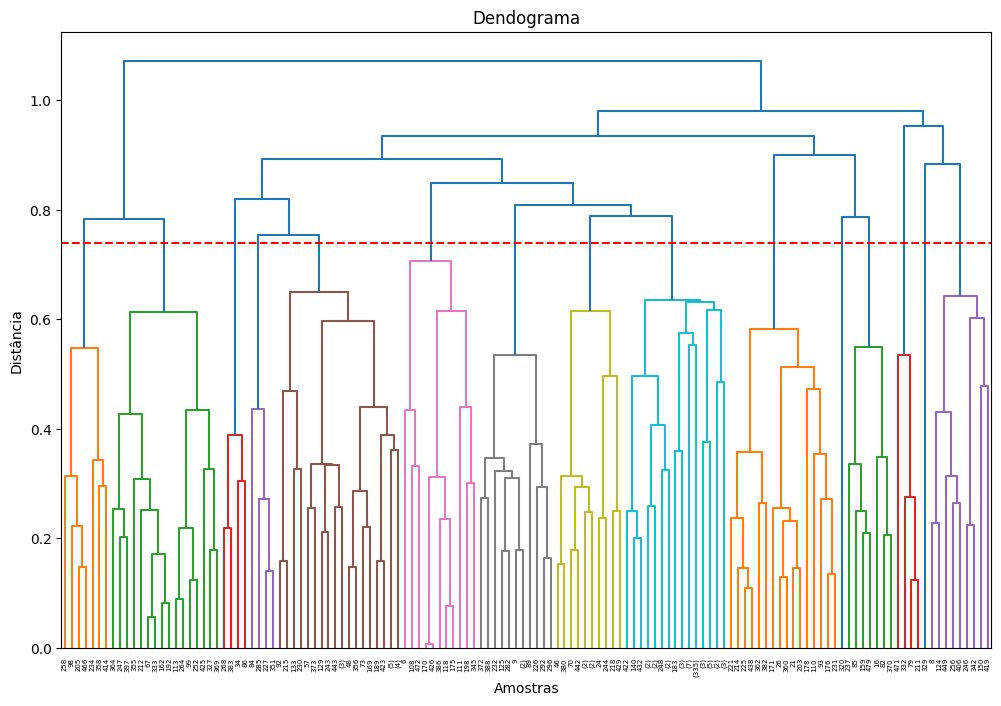

Silhouette Score para 15 clusters: 0.35


In [6]:
X_train_tfidf_subset= X_train_tfidf.toarray()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_tfidf_subset[:500])

# Redução de dimensionalidade com PCA
pca = PCA(n_components=10,random_state=42)
X_train_tfidf_subset = pca.fit_transform(X_scaled)
cosine_distances = pdist(X_train_tfidf_subset, metric='cosine')

threshold = 0.74

# Distâncias hierárquicas
linkage_matrix = linkage(cosine_distances, method='average')
dendro_labels = fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = len(set(dendro_labels))
print(f'Número de labels no dendograma: {n_clusters}')

# Dendograma
plt.figure(figsize=(12, 8))
dendro = dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.title('Dendograma')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.show()

# Número de clusters a partir do dendograma
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine',linkage='average')
labels = hierarchical_clustering.fit_predict(X_train_tfidf_subset)

# Silhouette Score para os clusters hierárquicos
silhouette = silhouette_score(X_train_tfidf_subset, labels, metric='cosine')
print(f'Silhouette Score para {n_clusters} clusters: {silhouette:.2f}')

Em primeiro lugar, fez-se a normalização de dados, de forma a garantir que os valores tenham uma média de 0 e desvio padrão de 1.

Aplicou-se o **PCA (Principal Component Analysis)** com o objetido de reduzir a dimensionalidade dos dados normalizados para 10 componentes principais e calculou-se as distâncias entre as métricas para medir a similaridade entre vetores.

Com a matriz de distâncias, construiu-se um **linkage hierárquico** e, com a função`fcluster`, determinou-se os rótulos de clusters com base em um limite de distância igual a 0.74. O número de clusters é o número de rótulos únicos.

O **dendograma** é responsável por mostrar a estrutura hierárquica dos clusters formados.
Para escolher o número de clusters observou-se o dendrograma e decidiu-se uma região de corte com base na distância (variável threshold), de forma a tentar agrupar clusters com a mesma label. Depois de definir a linha de corte, inferiu-se o número de grupos que a interseta e definiu-se o número de clusters iniciais.

In [7]:
def cluster_numbers(value=3, n_clusters=12):
    cluster_range = np.arange(n_clusters - value, n_clusters + value + 1)
    silhouette_scores = {}
    for n in cluster_range:
        hierarchical_clustering = AgglomerativeClustering(n_clusters=n, metric='cosine', linkage='average')
        labels = hierarchical_clustering.fit_predict(X_train_tfidf_subset)
        silhouette = silhouette_score(X_train_tfidf_subset, labels, metric='cosine')
        silhouette_scores[n] = silhouette
        print(f'Silhouette Score para {n} clusters: {silhouette:.2f}')
    
    best_n_clusters = max(silhouette_scores, key=silhouette_scores.get)
    best_score = silhouette_scores[best_n_clusters]
    
    print(f'\nMelhor número de clusters: {best_n_clusters} com Silhouette Score: {best_score:.2f}')
    return best_n_clusters

best_n_clusters= cluster_numbers(value=5, n_clusters=n_clusters)

hierarchical_clustering = AgglomerativeClustering(n_clusters=best_n_clusters, metric='cosine',linkage='average')
labels = hierarchical_clustering.fit_predict(X_train_tfidf_subset)
silhouette = silhouette_score(X_train_tfidf_subset, labels, metric='cosine')

Silhouette Score para 10 clusters: 0.35
Silhouette Score para 11 clusters: 0.36
Silhouette Score para 12 clusters: 0.37
Silhouette Score para 13 clusters: 0.36
Silhouette Score para 14 clusters: 0.36
Silhouette Score para 15 clusters: 0.35
Silhouette Score para 16 clusters: 0.34
Silhouette Score para 17 clusters: 0.34
Silhouette Score para 18 clusters: 0.33
Silhouette Score para 19 clusters: 0.31
Silhouette Score para 20 clusters: 0.31

Melhor número de clusters: 12 com Silhouette Score: 0.37


Posteriormente, através de uma gama, avaliou-se o **silhouette score** mais alto e escolheu-se o número de clusters correspondente. 

In [ ]:
custom_stop_words = ['great', 'charact', 'watch','someth','actor', 'look','episod', 'good', 'just','scene', 'howev', 'end', 'film', 'director',
'acting', 'way', 'life', 'movi', 'time', 'becaus', 'cinema', 'really', 'think', 'stori', 'know', 'year', 'make', 'like', 'thing', 'people', 'story']
combined_stop_words = list(set(tfidf.get_stop_words()).union(custom_stop_words))
clustered_texts = pd.DataFrame({'text': X_train[:len(X_train_tfidf_subset)], 'cluster': labels})

# Conta as palavras mais frequentes em um cluster
def get_top_words(texts, top_n=10):
    tfidf_vectorizer = TfidfVectorizer(stop_words=combined_stop_words,ngram_range=(1, 2), token_pattern=tp)
    X_tfidf_cluster = tfidf_vectorizer.fit_transform(texts)
    
    tfidf_scores = np.asarray(X_tfidf_cluster.mean(axis=0)).flatten()
    words = tfidf_vectorizer.get_feature_names_out()
    
    top_words = sorted(zip(words, tfidf_scores), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words

# Iterar pelos clusters e visualizar palavras mais representativas
for cluster_id in range(best_n_clusters):
    print(f"\nCluster {cluster_id}")
    cluster_texts = clustered_texts[clustered_texts['cluster'] == cluster_id]['text']
    
    top_words = get_top_words(cluster_texts, top_n=10)
    for word, score in top_words:
        print(f"{word}: {score:.4f}")


Cluster 0
christian: 0.0516
noth: 0.0466
church: 0.0457
half: 0.0452
girl: 0.0418
book: 0.0413
iran: 0.0388
brother: 0.0366
real: 0.0360
peopl: 0.0340

Cluster 1
prot: 0.0314
realli: 0.0308
veri: 0.0267
onli: 0.0251
jame: 0.0245
mani: 0.0238
seri: 0.0235
vita: 0.0227
perform: 0.0221
love: 0.0210

Cluster 2
littl: 0.0270
love: 0.0218
play: 0.0209
music: 0.0204
veri: 0.0203
plot: 0.0202
best: 0.0194
realli: 0.0193
onli: 0.0178
come: 0.0178

Cluster 3
veri: 0.0427
island: 0.0378
child: 0.0369
ford: 0.0337
need: 0.0305
wonder: 0.0293
happen: 0.0284
write: 0.0264
role: 0.0260
shark: 0.0252

Cluster 4
veri: 0.0150
love: 0.0149
realli: 0.0136
onli: 0.0135
plot: 0.0114
seen: 0.0110
peopl: 0.0100
play: 0.0095
better: 0.0093
mani: 0.0092

Cluster 5
anna: 0.0377
veri: 0.0342
hype: 0.0329
work: 0.0311
minut: 0.0309
better: 0.0294
gore: 0.0282
horror: 0.0274
plot: 0.0272
hous: 0.0267

Cluster 6
onli: 0.0452
play: 0.0409
veri: 0.0401
thunderbird: 0.0374
basterd: 0.0289
nazi: 0.0289
amech: 0.0286
ni

Por fim, adicionou-se algumas stop words de forma a filtrar palavras irrelevantes para o contexto de agrupamento. 
- `custom_stop_words`* Lista de palavras irrelevantes específicas para este contexto, como "great", "movie", "story", etc.
- `combined_stop_words`: Combina as stop words padrão do **TF-IDF Vectorizer** com as palavras personalizadas, garantindo que ambas as listas sejam consideradas ao calcular TF-IDF.

Os dados são estruturizados com um **DataFrame** que associa os textos originais (`X_train`) aos rótulos de cluster (`labels`) gerados pelo modelo de clustering hierárquico.

Para a identificação das palavras representativas, configurou-se o vetorizador de forma a remover as stop words combinadas, calculou-se a matriz TF-IDF e as suas pontuações médias de TF-IDF e extraiu-se as palavras e pontuações. Depois, para cada cluster, filtrou-se os textos que pertencem ao cluster atual e obteu-se as `top_n` palavras com maior pontuação TF-IDF.


Assim, conseguiu-se separar as críticas pelo contexto em que são escritas e/ou género do filme, pela frequência com que certas palavras são usadas, por exemplo: 
 - christian, church:  temas religiosos;
 - play, music:  musicais;
 - student, campus: ambiente escolar;
 - german, nazi: guerras mundiais;
 - etc...

<a id="conclusao"></a>

#### 6. Conclusão
Este trabalho prático permitiu explorar técnicas fundamentais de aprendizagem autómáticas no contexto de análise de texto. Foi possícel implementar e avaliar algoritmos de classificação, regressão e clustering, extraindo informação relevante a partir de dados textuais não estruturados.<br><br>
Os resultados obtidos validam a eficácia das metodologias adotadas e a análise das métricas de desempenho e das abordagens de validação reforçou o entendimento sobre os desafios e limitações associados à aprendizagem automática em cenários reais.<br><br>
Este projeto não apenas consolidou conhecimentos teóricos, mas também proporcionou uma experiência prática valiosa no manuseio de dados, escolha de modelos e avaliação de resultados, contribuindo para o desenvolvimento de competências essenciais no domínio da ciência de dados e inteligência artificial.

<a id="refs"></a>

#### 7. Referências

* <a href="https://2425moodle.isel.pt/course/view.php?id=8502" target="_blank">Acetatos de Aprendizagem Automática, Moodle ISEL</a>